In [1]:
import pyxdf
import mne
import numpy as np
import pandas as pd
import random

In [2]:
# สร้าง list เพื่อเก็บ index ของ epoch ที่ต้องการลบ event_id ออก
def count_each_class(mne_epochs, num_class):
    indices_to_drop = []
    num_class = num_class

    # Iterate ผ่านทุกๆ epoch
    for idx, epoch in enumerate(mne_epochs):
        # ตรวจสอบว่า event_id เป็น {'natural': 0} หรือไม่
        if mne_epochs.events[idx, -1] == num_class:  # ตรวจสอบ event_id ในข้อมูล events ของ epoch นั้นๆ
            # เพิ่ม index ของ epoch ที่ต้องการลบออกใน list
            indices_to_drop.append(idx)

    # ลบ epoch ที่มี event_id เป็น {'natural': 0} ออกจาก mne_epochs
    return indices_to_drop
    # mne_epochs.drop(indices_to_drop)

In [3]:
def random_drop_to_balance(mne_epochs, class_counts):
    # หาจำนวนของ class ที่มีจำนวนน้อยสุด
    # print(class_counts)
    min_count = min(class_counts)
    
    # สร้าง list เพื่อเก็บ index ของแต่ละ class
    class_indices = [[] for _ in range(len(class_counts))]

    # นับ index ของแต่ละ class
    for idx, epoch in enumerate(mne_epochs):
        event_id = mne_epochs.events[idx, -1]
        class_indices[event_id].append(idx)

    # สุ่มลำดับ index ของแต่ละ class เพื่อทำการลบ
    random_indices_to_drop = []
    for indices in class_indices:
        # สุ่มลำดับ index ที่ต้องการลบออก
        if len(indices) > len(min_count):
            random_indices = random.sample(indices, len(indices) - len(min_count))
            random_indices_to_drop.extend(random_indices)
    
    # ลบ epoch ที่ต้องการออกจาก mne_epochs
    mne_epochs.drop(random_indices_to_drop)

    return random_indices_to_drop

In [4]:
streams, header = pyxdf.load_xdf("C:/Users/Toey/Desktop/data_ssvep/Toey/exp1/block_2.xdf")

In [5]:
raw_data = streams[0]["time_series"].T #From Steam variable this query is EEG data
event_index = streams[1]["time_series"].T[0] #Get all event marker of experiment 
#.T คือ transpose array [0] data ใน column 0 ของ streams[1]["time_series"]
event_timestamp = streams[1]["time_stamps"].T #Timestamp when event marked
channels =['Fz','Cz','P4','Pz','P3','P08','Oz','P07'] #Set your target EEG channel name
info = mne.create_info(
    ch_names= channels,
    ch_types= ['eeg']*len(channels),
    sfreq= 250 #OpenBCI Frequency acquistion
)
# Create MNE rawarray
raw_mne = mne.io.RawArray(raw_data, info, verbose=False)


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


C:\Users\Toey\AppData\Local\Temp\ipykernel_24968\676745226.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_mne.plot_psd()
C:\Users\Toey\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


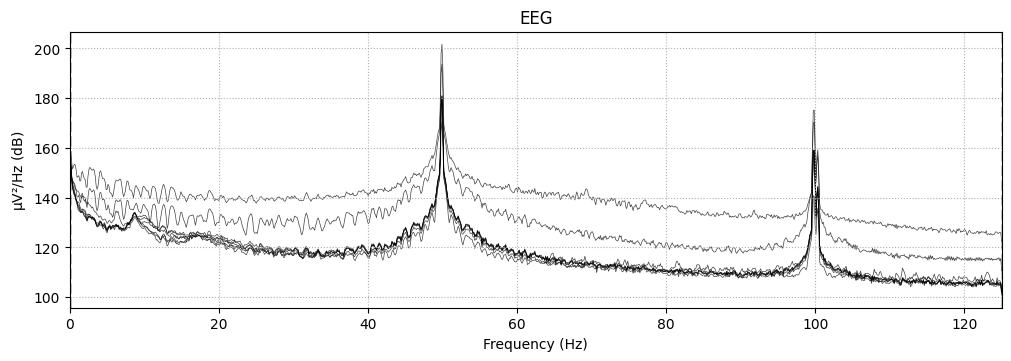

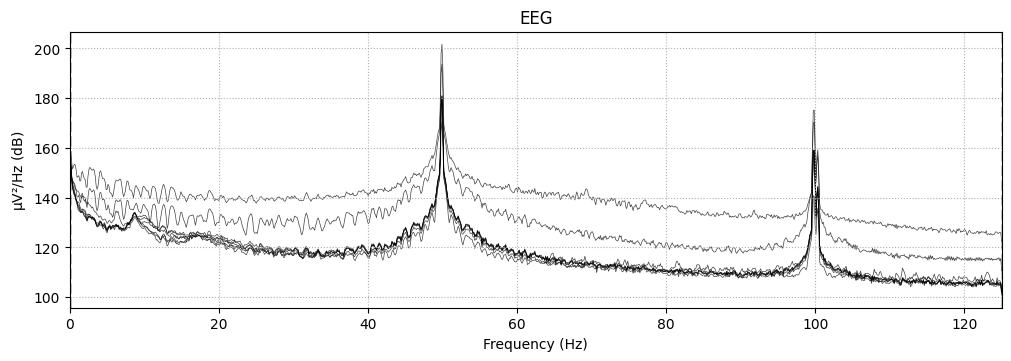

In [6]:
raw_mne.plot_psd()

In [7]:
low_freq = 8.0
high_freq = 12.0
raw_mne_filtered = raw_mne.copy().filter(l_freq=low_freq,h_freq=high_freq)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 413 samples (1.652 s)



NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


C:\Users\Toey\AppData\Local\Temp\ipykernel_24968\2242267490.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_mne_filtered.plot_psd()
C:\Users\Toey\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


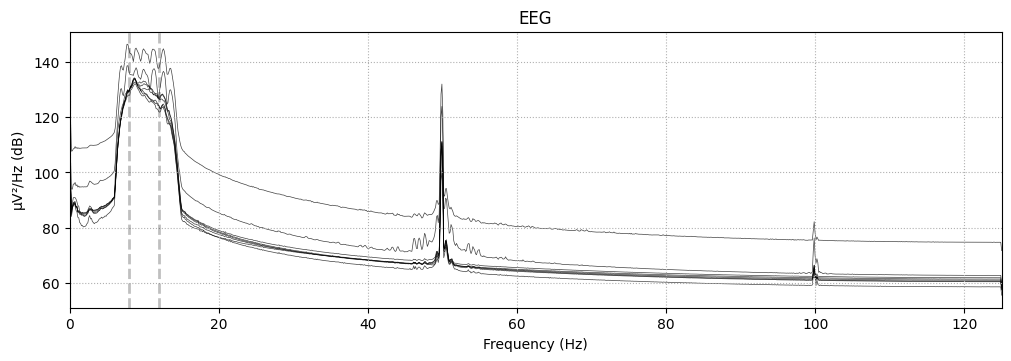

In [8]:
raw_mne_filtered.plot_psd()

In [9]:
raw_mne_CAR = raw_mne_filtered.copy().set_eeg_reference('average', projection=True)
raw_mne_CAR.apply_proj()

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,8.00 Hz
Lowpass,12.00 Hz


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


C:\Users\Toey\AppData\Local\Temp\ipykernel_24968\3417849396.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_mne_CAR.plot_psd()
C:\Users\Toey\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


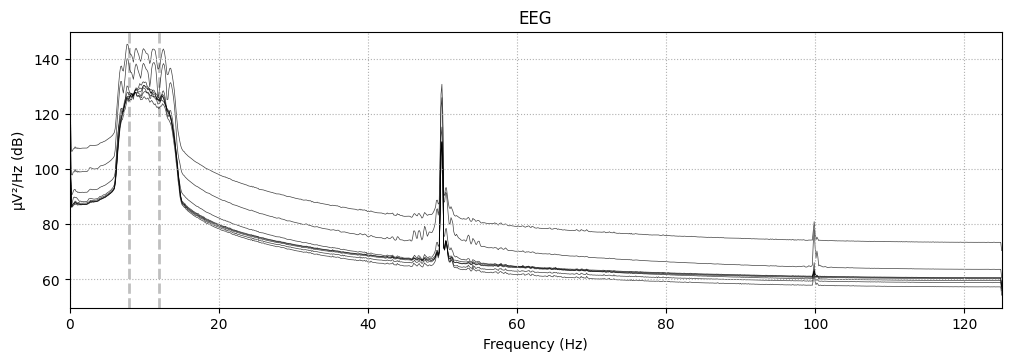

In [10]:
raw_mne_CAR.plot_psd()

In [11]:
events = np.column_stack((np.array(event_timestamp, dtype = int),
                        np.zeros(len(event_timestamp), dtype = int),
                        np.array(event_index, dtype = int)))
fre1 = 8
fre2 = 10
fre3 = 12
fre4 = 14
events_id = { # Set up your event name
     f'natural': 0,
     f'Frequency {fre1} Hz': 1,
     f'Frequency {fre2} Hz': 2,
     f'Frequency {fre3} Hz': 3,
     f'Frequency {fre4} Hz': 4,
}
mne_epochs = mne.Epochs(raw_mne, events, 
        tmin= -0.5,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax= 20,    # final timestamp (10 means set epoch duration 10 second)
        event_id =events_id,
        preload = True,
        event_repeated='drop',
        baseline=(-0.5, 0)
    )
mne_epochs

Not setting metadata
180 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 180 events and 5126 original time points ...
0 bad epochs dropped


Number of events,180
Events,Frequency 10 Hz: 20Frequency 12 Hz: 20Frequency 14 Hz: 21Frequency 8 Hz: 20natural: 99
Time range,-0.500 – 20.000 s
Baseline,-0.500 – 0.000 s


In [12]:
# จัดการให้จำนวนข้อมูลแต่ละ class นั้นเท่ากัน
class0 = count_each_class(mne_epochs, 0)
class1 = count_each_class(mne_epochs, 1)
class2 = count_each_class(mne_epochs, 2)
class3 = count_each_class(mne_epochs, 3)
class4 = count_each_class(mne_epochs, 4)

class_counts = [class0, class1, class2, class3, class4]
random_indices_to_drop = random_drop_to_balance(mne_epochs, class_counts)
mne_epochs

Dropped 80 epochs: 1, 3, 5, 7, 8, 12, 16, 17, 19, 23, 26, 32, 34, 35, 37, 41, 43, 44, 48, 50, 51, 53, 57, 59, 61, 62, 64, 66, 70, 71, 73, 75, 77, 79, 80, 82, 84, 86, 88, 89, 93, 95, 97, 98, 100, 102, 104, 106, 107, 109, 113, 115, 116, 118, 120, 125, 127, 129, 131, 133, 134, 136, 138, 140, 143, 145, 147, 149, 151, 152, 154, 156, 158, 160, 161, 163, 167, 169, 170, 174


Number of events,100
Events,Frequency 10 Hz: 20Frequency 12 Hz: 20Frequency 14 Hz: 20Frequency 8 Hz: 20natural: 20
Time range,-0.500 – 20.000 s
Baseline,-0.500 – 0.000 s


In [13]:
# ข้อมูลที่สามารถนำไปใช้ได้
x = mne_epochs.get_data()
y = mne_epochs.events[:, -1]

C:\Users\Toey\AppData\Local\Temp\ipykernel_24968\1443414176.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x = mne_epochs.get_data()
